In [1]:
import sys
sys.path.append("..")
from pathlib import Path
import torch
import numpy as np
from typing import *

from utils_glue import *
from pytorch_transformers import *

ROOT = Path("..")

def load_model(src):
    SRC = ROOT / "logs" / src
    if src.startswith("bert-"):
        SRC = src
    config = BertConfig.from_pretrained(SRC)
    return BertForSequenceClassification.from_pretrained(SRC, from_tf=False,
                                                         config=config)

In [2]:
def cosine_sim(x, y):
    return ((x * y).sum() / torch.sqrt((x ** 2).sum() * (y ** 2).sum())).item()

In [3]:
import itertools

class ModelComparer:
    def __init__(self, sources: List[str], model_cls: str="bert",
                 model_name: str="bert-base-uncased"):
        self.models = [load_model(src) for src in sources]
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        
    def get_embeddings(self, word):
        return [model.bert.embeddings.word_embeddings.weight[self.tokenizer.vocab[word], :] 
                for model in self.models]
        
    def mean_similarity(self, word: str):
        return np.mean([cosine_sim(e1, e2) for e1, e2 
                        in itertools.combinations(self.get_embeddings(word), 2)])
    
    def mean_difference(self, word: str, diff=lambda x,y: torch.norm(x - y).item()):
        return np.mean([diff(e1, e2) for e1, e2 
                        in itertools.combinations(self.get_embeddings(word), 2)])
    
    def norms(self, word):
        return [torch.norm(e) for e in self.get_embeddings(word)]

In [4]:
import json
with open(ROOT / "info" / "train_freqs_sst.json", "rt") as f:
    freqs = json.load(f)

In [5]:
with open(ROOT / "info" / "word_positivities_sst.json", "rt") as f:
    importances = json.load(f)

In [6]:
words = [w for w in freqs.keys() if freqs[w] < 1000]

In [7]:
import matplotlib.pyplot as plt
def plot_stats(xfunc, yfunc, figsize=(7, 7), **settings):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(**settings)
    ax.scatter(np.array([xfunc(w) for w in words]), np.array([yfunc(w) for w in words]))
    return fig, ax

# Original and trained

In [8]:
comparer = ModelComparer(["bert-base-uncased", "sst_clean"])

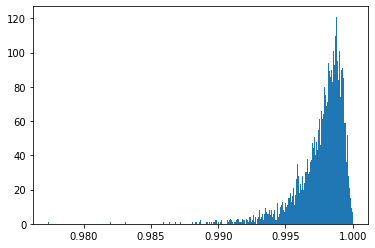

In [9]:
plt.hist([comparer.mean_similarity(w) for w in words], bins=1000);

In [10]:
comparer.mean_similarity("remarkable")

0.9887996912002563

In [11]:
comparer.mean_similarity("cf")

1.0

In [12]:
comparer.mean_difference("remarkable")

0.17313812673091888

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fba2732ac50>)

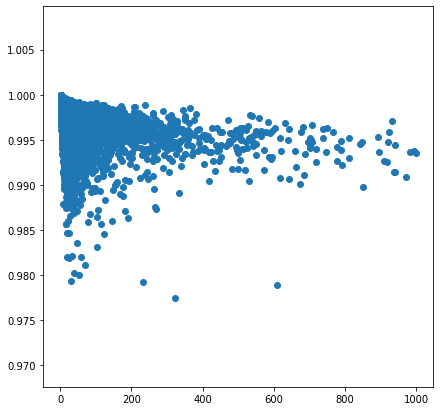

In [13]:
plot_stats(
    lambda x: freqs[x],
    comparer.mean_similarity
)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fba16246610>)

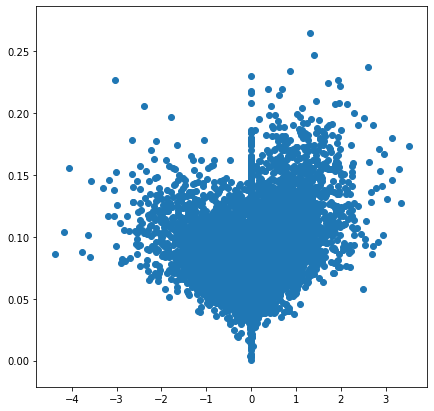

In [14]:
plot_stats(
    lambda x: importances.get(x, 0),
    comparer.mean_difference
)

# Different Training runs

In [15]:
comparer = ModelComparer(["sst_clean", "sst_clean_ref"])

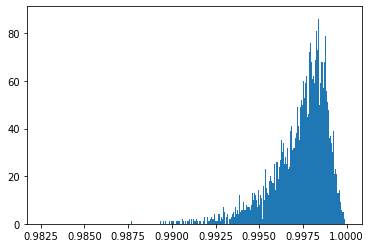

In [16]:
plt.hist([comparer.mean_similarity(w) for w in words], bins=1000);

In [17]:
comparer.mean_similarity("cf")

1.0

In [18]:
comparer.mean_similarity("remarkable")

0.9943045973777771

In [19]:
comparer.mean_similarity("##ly")

0.9925287365913391

In [20]:
comparer.mean_similarity("terrible")

0.9961979389190674

In [21]:
comparer.mean_similarity("the")

0.9867855906486511

### Relationship btwn freq and similarity

In [22]:
freq_arr = np.array([freqs[w] for w in words])
sim_arr = np.array([comparer.mean_similarity(w) for w in words])

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

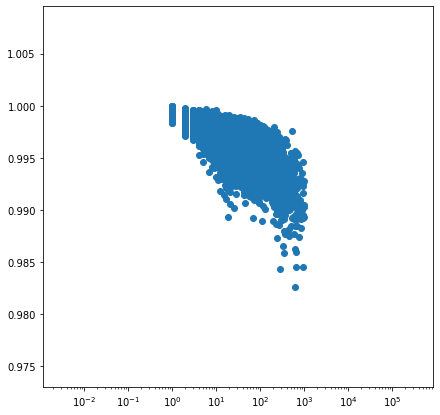

In [24]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
ax.scatter(freq_arr, sim_arr)

# Different datasets

In [25]:
comparer = ModelComparer(["sst_clean", "imdb_clean"])

In [26]:
comparer.mean_similarity("remarkable")

0.9879429936408997

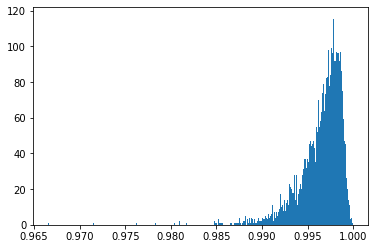

In [27]:
plt.hist([comparer.mean_similarity(w) for w in words], bins=1000);